# Understanding Image Sharpness Map Generation

This notebook explores an implementation of image sharpness map generation using various image processing techniques including DCT (Discrete Cosine Transform), edge detection, and recursive filtering.


### Function Purpose:
The `sharpness_map` function computes a sharpness map for an input image, utilizing frequency-domain analysis and recursive filtering techniques.

### Discrete Cosine Transform (DCT) Matrix Creation:
The `dctmtx` function generates a DCT matrix, essential for transforming image patches into the frequency domain for sharpness evaluation.

### DCT Coefficients Calculation:
The `getDCTCoefficients` function computes DCT coefficients for a given image block using precomputed DCT matrices. These coefficients highlight frequency components that correlate with sharpness.

### Recursive Filtering:
The `RF` function implements edge-aware image filtering based on spatial and intensity differences, smoothing the image while preserving edges.

### Gradient Computation:
The input image is blurred using a Gaussian filter (`cv2.GaussianBlur`) to reduce noise. Sobel filters (`cv2.Sobel`) then compute the horizontal and vertical gradients, and the gradient magnitude is derived for edge detection.

### Scale and Frequency Band Analysis:
Multiple scales are calculated to assess sharpness across different resolutions. Frequency bands are defined for each scale, segmenting the frequency domain into regions of interest.

### Feature Extraction and High-Frequency Component Analysis:
Image patches are extracted and transformed into the frequency domain. High-frequency components, indicative of sharp edges, are analyzed and aggregated.

### Normalization and Sharpness Aggregation:
The extracted frequency components are normalized, and a sharpness score is computed for each patch. These scores are used to generate the sharpness map.

### Entropy Weighting:
Local entropy, a measure of randomness, is calculated and combined with the sharpness scores to enhance the map's sensitivity to sharp regions.

### Recursive Filtering on Final Map:
The weighted sharpness map is refined using recursive filtering to smooth the results while maintaining edge integrity.

### Output Generation:
The final sharpness map is resized to match the input image dimensions and returned as the result.


In [6]:
import numpy as np
import cv2
import copy
from skimage.filters.rank import entropy
from skimage.morphology import square

def sharpness_map(img):
    """
    Computes a sharpness map for the input image using domain transform and DCT coefficients.
    
    Parameters:
        img (numpy.ndarray): Grayscale input image.

    Returns:
        numpy.ndarray: Sharpness map of the image.
    """

    def dctmtx(n):
        """Generates the Discrete Cosine Transform (DCT) matrix of size n x n."""
        mesh_cols, mesh_rows = np.meshgrid(np.linspace(0, n - 1, n), np.linspace(0, n - 1, n))
        dct_matrix = np.sqrt(2 / n) * np.cos(np.pi * np.multiply((2 * mesh_cols + 1), mesh_rows) / (2 * n))
        dct_matrix[0, :] /= np.sqrt(2)
        return dct_matrix

    def getDCTCoefficients(img_blk, ind):
        """Computes the DCT coefficients for a given image block."""
        rows, cols = img_blk.shape
        D = dct_matrices[ind]
        dct_coeff = np.matmul(np.matmul(D, img_blk), np.transpose(D))
        return dct_coeff

    def TransformedDomainRecursiveFilter_Horizontal(I, D, sigma):
        """Applies the transformed domain recursive filter in the horizontal direction."""
        a = np.exp(-np.sqrt(2) / sigma)  # Feedback coefficient
        F = copy.deepcopy(I)
        V = a ** D
        rows, cols = I.shape

        # Left-to-Right Filtering
        for i in range(1, cols):
            F[:, i] += V[:, i] * (F[:, i - 1] - F[:, i])

        # Right-to-Left Filtering
        for i in range(cols - 2, 0, -1):
            F[:, i] += V[:, i + 1] * (F[:, i + 1] - F[:, i])

        return F

    def RF(img, joint_img):
        """Recursive filtering with joint image guidance."""
        joint_img = joint_img.astype('float64') / 255
        cols, rows = joint_img.shape[:2]

        # Compute partial derivatives
        dIcdx = np.diff(joint_img, n=1, axis=1)
        dIcdy = np.diff(joint_img, n=1, axis=0)

        dIdx = np.zeros_like(joint_img)
        dIdy = np.zeros_like(joint_img)

        dIdx[:, 1:] = abs(dIcdx)
        dIdy[1:, :] = abs(dIcdy)

        sigma_s_RF_filter = 15
        sigma_r_RF_filter = 0.25
        dHdx = (1 + sigma_s_RF_filter / sigma_r_RF_filter * dIdx)
        dVdy = (1 + sigma_s_RF_filter / sigma_r_RF_filter * dIdy)

        dVdy = np.transpose(dVdy)
        N = 3
        F = copy.deepcopy(img)

        for i in range(3):
            sigma_H_i = sigma_s_RF_filter * np.sqrt(3) * 2 ** (N - (i + 1)) / np.sqrt(4 ** N - 1)
            F = TransformedDomainRecursiveFilter_Horizontal(F, dHdx, sigma_H_i)
            F = np.transpose(F)
            F = TransformedDomainRecursiveFilter_Horizontal(F, dVdy, sigma_H_i)
            F = np.transpose(F)

        return F

    # Preprocess image with Gaussian blur
    InputImageGaus = cv2.GaussianBlur(img, (3, 3), sigmaX=0.5, sigmaY=0.5)

    # Compute gradient magnitude
    sobelx = cv2.Sobel(InputImageGaus, cv2.CV_64F, 1, 0, borderType=cv2.BORDER_REFLECT)
    sobely = cv2.Sobel(InputImageGaus, cv2.CV_64F, 0, 1, borderType=cv2.BORDER_REFLECT)
    gradient_image = np.sqrt(sobelx**2 + sobely**2)

    # Define scales and compute DCT matrices
    num_scales = 4
    scales = [(2**(3 + i)) - 1 for i in range(num_scales)]
    dct_matrices = [dctmtx(scale) for scale in scales]

    # Define frequency bands
    freqBands = []
    for current_scale in scales:
        matrixInds = np.zeros((current_scale, current_scale))
        for i in range(current_scale):
            matrixInds[:max(0, int(((current_scale - 1) / 2) - i + 1)), i] = 1
            if current_scale - ((current_scale - 1) / 2) - i <= 0:
                matrixInds[:current_scale - i - 1, i] = 2
            else:
                matrixInds[int(current_scale - ((current_scale - 1) / 2) - i - 1):int(current_scale - i - 1), i] = 2
        matrixInds[0, 0] = 3
        freqBands.append(matrixInds)

    # Prepare image for processing
    padded_image = np.pad(gradient_image, int(np.floor(max(scales) / 2)), mode='constant')
    rows, cols = padded_image.shape
    downsampling_factor = 4
    total_num_layers = 1 + sum(scales)
    total_num_points = len(range(int(max(scales) / 2), rows - int(max(scales) / 2), downsampling_factor)) * len(range(int(max(scales) / 2), cols - int(max(scales) / 2), downsampling_factor))
    L = np.zeros((total_num_points, total_num_layers))

    # Process image
    iter = 0
    for i in range(int(max(scales) / 2), rows - int(max(scales) / 2), downsampling_factor):
        for j in range(int(max(scales) / 2), cols - int(max(scales) / 2), downsampling_factor):
            high_freq_components = []
            for ind, curr_scale in enumerate(scales):
                Patch = padded_image[i - int(curr_scale / 2):i + int(curr_scale / 2) + 1, j - int(curr_scale / 2):j + int(curr_scale / 2) + 1]
                dct_coefficients = np.abs(getDCTCoefficients(Patch, ind))
                high_freq_components.append(dct_coefficients[freqBands[ind] == 0])
            high_freq_components = np.hstack(high_freq_components)
            result = np.argpartition(high_freq_components, total_num_layers)
            L[iter, :] = high_freq_components[result[:total_num_layers]]
            iter += 1

    # Normalize L matrix
    for i in range(total_num_layers):
        L[:, i] /= max(L[:, i])

    # Compute sharpness map
    n, m = len(range(int(max(scales) / 2), rows - int(max(scales) / 2), downsampling_factor)), len(range(int(max(scales) / 2), cols - int(max(scales) / 2), downsampling_factor))
    T_max = np.zeros((n, m))
    for ind1d, val in enumerate(np.sqrt(np.sum(L**2, axis=1))):
        T_max[ind1d // m, ind1d % m] = val

    T_max /= T_max.max()
    local_entropy = entropy(T_max, square(7))
    weighted_local_entropy = np.multiply(local_entropy, T_max)

    # Apply final filtering
    resized_input_image = cv2.resize(InputImageGaus, (weighted_local_entropy.shape[1], weighted_local_entropy.shape[0]))
    aSmooth = cv2.GaussianBlur(resized_input_image, (3, 3), sigmaX=1, sigmaY=1)
    final_map = RF(weighted_local_entropy, aSmooth)

    # Resize final map to original dimensions
    final_map = cv2.resize(final_map, (img.shape[1], img.shape[0]))

    return final_map


# Depth Map Generation from Focal Stack

This process involves computing a depth map from a focal stack of images using sharpness maps. Below is a step-by-step breakdown:

## Steps

1. **Compute Sharpness Maps:**
   - For each image in the focal stack, compute a sharpness map using the `sharpness_map1` function. This function analyzes the frequency-domain information of the image to identify sharp regions, which correspond to areas in focus.

2. **Normalize the Sharpness Maps:**
   - Sum all the sharpness maps across the stack to create a normalization factor:
    
   - Normalize each sharpness map by dividing it by the normalization factor:
    

3. **Weight the Normalized Sharpness Maps with Frame Index:**
   - Multiply each normalized sharpness map by its frame index to assign weights corresponding to the image's depth in the stack:
     
4. **Aggregate Weighted Sharpness Maps into a Depth Map:**
   - Sum all the weighted sharpness maps to generate the final depth map:
     
## Summary
- The **sharpness map** highlights in-focus regions of each image in the stack.
- **Normalization** ensures consistency across sharpness maps by accounting for the cumulative sharpness of all images.
- **Weighting by frame index** aligns sharpness maps with their respective depths in the focal stack.
- The final **depth map** encodes depth information based on the sharpness and order of images in the stack.




In [ ]:
import os
import matplotlib.pyplot as plt
path = r"D:\AVWS\Results\balls\balls_focal_stack"
ls = os.listdir(path)
fram_ls = []
for i in ls[::3]:
    image = cv2.imread(path+"\\"+i,0)
    final_map = sharpness_map(image)
    fram_ls.append(final_map)

In [8]:
temp1 = np.sum(np.array(fram_ls), axis= 0) 
temp2 = 1 
ls2 = [] 
for i in fram_ls/temp1: 
    ls2.append(i*temp2) 
    temp2+=1 
depthmap = np.sum(ls2, axis=0) 

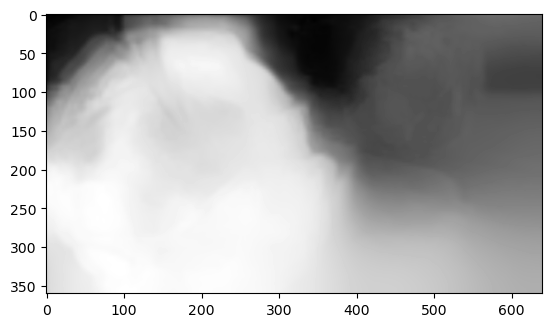

In [10]:
plt.imshow(depthmap,cmap='gray')

# Trimap Generation

In [14]:
depth_map = cv2.normalize(depthmap, None, 0, 255, cv2.NORM_MINMAX)

In [17]:
depth_map = np.uint8(depth_map)


Otsu's threshold value: 151.0


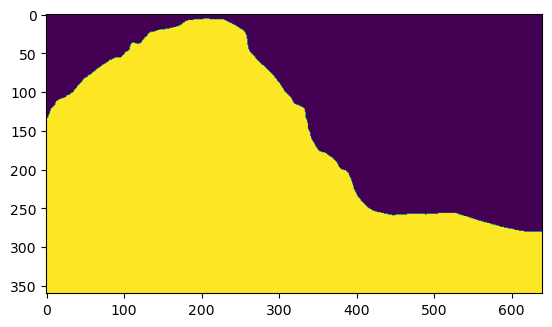

In [18]:
thresh_val, thresh_img = cv2.threshold(depth_map, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(f"Otsu's threshold value: {thresh_val}")
plt.imshow(thresh_img)

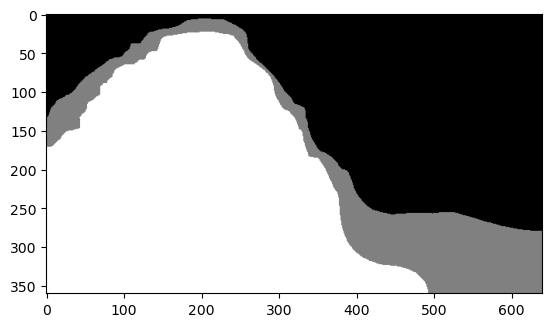

In [22]:
# Define foreground and background thresholds (adjust these values as needed)
foreground_threshold = thresh_val + 50  #200  # Example threshold for foreground
background_threshold = thresh_val   # Example threshold for background

# Thresholding to segment the depth map
foreground_mask = (depth_map > foreground_threshold).astype(np.uint8)
background_mask = (depth_map < background_threshold).astype(np.uint8)

# Perform morphological operations (dilation and erosion) for smoother transitions
kernel = np.ones((5, 5), np.uint8)
foreground_mask = cv2.dilate(foreground_mask, kernel, iterations=3)
background_mask = cv2.dilate(background_mask, kernel, iterations=3)
foreground_mask = cv2.erode(foreground_mask, kernel, iterations=3)
background_mask = cv2.erode(background_mask, kernel, iterations=3)

# Create the trimap
trimap = np.zeros_like(depth_map)
trimap[foreground_mask == 1] = 255  # Foreground
trimap[background_mask == 1] = 0    # Background
trimap[(foreground_mask == 0) & (background_mask == 0)] = 128  # Uncertain region

plt.imshow(trimap, cmap='gray')

In [23]:
cv2.imwrite(r"D:\AVWS\Results\balls\results\trimap.jpg", trimap)

True